In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-grouped/data_grouped.csv
/kaggle/input/data-class/data.csv


In [201]:
import pandas as pd

df = pd.read_csv('/kaggle/input/data-class/data.csv')
df.head()

,unix_time,datetime,person,value,activity,sleep_duration,stress_lvl
0,1706086869,2024-01-24 10:01:09,Anh,171.1,Chill,8.0,0.457849
1,1706086870,2024-01-24 10:01:10,Anh,171.0,Chill,8.0,0.458344
2,1706086872,2024-01-24 10:01:12,Anh,170.9,Chill,8.0,0.458838
3,1706086873,2024-01-24 10:01:13,Anh,170.8,Chill,8.0,0.459333
4,1706086874,2024-01-24 10:01:14,Anh,170.7,Chill,8.0,0.459827


In [202]:
import time
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df['datetime'].dt.hour
df.head()

,unix_time,datetime,person,value,activity,sleep_duration,stress_lvl
0,1706086869,10,Anh,171.1,Chill,8.0,0.457849
1,1706086870,10,Anh,171.0,Chill,8.0,0.458344
2,1706086872,10,Anh,170.9,Chill,8.0,0.458838
3,1706086873,10,Anh,170.8,Chill,8.0,0.459333
4,1706086874,10,Anh,170.7,Chill,8.0,0.459827


In [203]:
df.dtypes

unix_time           int64
datetime            int32
person             object
value             float64
activity           object
sleep_duration    float64
stress_lvl        float64
dtype: object

In [204]:
df['stress_lvl'] = df['stress_lvl'].round(0)
df.head()

,unix_time,datetime,person,value,activity,sleep_duration,stress_lvl
0,1706086869,10,Anh,171.1,Chill,8.0,0.0
1,1706086870,10,Anh,171.0,Chill,8.0,0.0
2,1706086872,10,Anh,170.9,Chill,8.0,0.0
3,1706086873,10,Anh,170.8,Chill,8.0,0.0
4,1706086874,10,Anh,170.7,Chill,8.0,0.0


In [207]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer

X = df.copy()
X.drop(columns=['stress_lvl', 'unix_time', 'person'], inplace=True)
y = df.stress_lvl

categorical_cols = ['activity']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_cols = ['datetime','value', 'sleep_duration']
numerical_transformer = make_pipeline(
    StandardScaler(),
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = to_categorical(y_train, num_classes=6)
y_valid = to_categorical(y_valid, num_classes=6)
input_shape = [X_train.shape[1]]

scaler = preprocessor.named_transformers_['num']
num_means = scaler.named_steps['standardscaler'].mean_
num_std = scaler.named_steps['standardscaler'].scale_

print("Mean of numerical columns:", num_means)
print("Standard deviation of numerical columns:", num_std)

Mean of numerical columns: [ 14.55020289 105.930505     7.42024268]
Standard deviation of numerical columns: [ 3.85559805 30.29517411  1.16461952]


In [208]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(units=32, activation='relu', input_shape=input_shape),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=6, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [209]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[keras.metrics.CategoricalAccuracy()]
)

In [210]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)


Epoch 1/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.3624 - loss: 1.3786 - val_categorical_accuracy: 0.5247 - val_loss: 1.0582
Epoch 2/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.5453 - loss: 1.0222 - val_categorical_accuracy: 0.5844 - val_loss: 0.9463
Epoch 3/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.5968 - loss: 0.9266 - val_categorical_accuracy: 0.6294 - val_loss: 0.8823
Epoch 4/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.6338 - loss: 0.8695 - val_categorical_accuracy: 0.6428 - val_loss: 0.8452
Epoch 5/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.6488 - loss: 0.8360 - val_categorical_accuracy: 0.6598 - val_loss: 0.8163
Epoch 6/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.6630 - loss: 0.8099 - val_categorical_accuracy: 0.6718 - val_loss: 0.7954
Epoch 7/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_a

<Axes: title={'center': 'Training and Validation Accuracy'}>

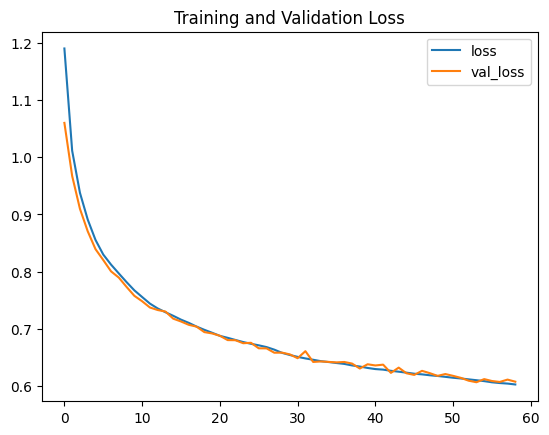

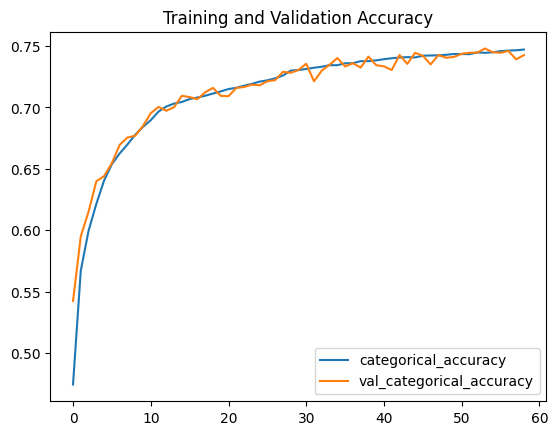

In [181]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Training and Validation Loss")
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(title="Training and Validation Accuracy")

In [222]:
data = {
    "datetime": [10.0, 19.0, 17.0, 20.0, 19.0],
    "value": [80, 80, 80, 105, 120],
    "activity": ['Work', 'Chill', 'Hobby', 'Uni', 'Social'],
    "sleep_duration": [8.0, 8.0, 8.0, 8.0, 8.0]
}

test_df = pd.DataFrame(data)

test_df['datetime'] = test_df['datetime'].astype('float64')
test_df['sleep_duration'] = test_df['sleep_duration'].astype('float64')
test_df.dtypes

datetime          float64
value               int64
activity           object
sleep_duration    float64
dtype: object

In [223]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# Define the mean and standard deviation values
mean_numerical = [14.55020289, 105.930505, 7.42024268]
std_numerical = [3.85559805, 30.29517411, 1.16461952]

# Define the categorical and numerical transformers
categorical_cols = ['activity']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_cols = ['datetime', 'value', 'sleep_duration']
numerical_transformer = make_pipeline(
    StandardScaler()
)

# Set the mean and standard deviation values for StandardScaler
numerical_transformer.named_steps['standardscaler'].mean_ = mean_numerical
numerical_transformer.named_steps['standardscaler'].scale_ = std_numerical

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing to test_df
test_df_pre = preprocessor.fit_transform(test_df)

print(test_df_pre)


[[-1.92668659 -0.78250805  0.          0.          0.          0.
   0.          1.        ]
 [ 0.55048188 -0.78250805  0.          1.          0.          0.
   0.          0.        ]
 [ 0.         -0.78250805  0.          0.          1.          0.
   0.          0.        ]
 [ 0.82572282  0.72231512  0.          0.          0.          0.
   1.          0.        ]
 [ 0.55048188  1.62520902  0.          0.          0.          1.
   0.          0.        ]]


In [224]:
prediction = model.predict(test_df_pre)
#prediction

print(prediction.argmax(axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0 3 3 3 2]


In [213]:
predicted_labels = prediction.argmax(axis=1)
print(predicted_labels)

[0]


In [164]:
for i, pred_probs in enumerate(prediction):
    print(f"Sample {i + 1} predicted probabilities:")
    for j, prob in enumerate(pred_probs):
        formatted_prob = "{:.2%}".format(prob)  # Format the probability as percentage with 2 decimal places
        print(f"Class {j}: {formatted_prob}")
    print()

Sample 1 predicted probabilities:
Class 0: 99.90%
Class 1: 0.10%
Class 2: 0.00%
Class 3: 0.00%
Class 4: 0.00%
Class 5: 0.00%

Sample 2 predicted probabilities:
Class 0: 91.93%
Class 1: 8.07%
Class 2: 0.00%
Class 3: 0.00%
Class 4: 0.00%
Class 5: 0.00%

Sample 3 predicted probabilities:
Class 0: 0.00%
Class 1: 0.21%
Class 2: 99.78%
Class 3: 0.00%
Class 4: 0.00%
Class 5: 0.00%

Sample 4 predicted probabilities:
Class 0: 100.00%
Class 1: 0.00%
Class 2: 0.00%
Class 3: 0.00%
Class 4: 0.00%
Class 5: 0.00%

Sample 5 predicted probabilities:
Class 0: 0.00%
Class 1: 99.96%
Class 2: 0.04%
Class 3: 0.00%
Class 4: 0.00%
Class 5: 0.00%



In [148]:

data = {
    "datetime": [9.0, 17.0, 17.0, 20.0, 19.0],
    "value": [70, 80, 80, 105, 120],
    "activity": ['Work', 'Chill', 'Hobby', 'Uni', 'Social'],
    "sleep_duration": [8.0, 6.0, 7.5, 5.0, 8.0]
}

test_df = pd.DataFrame(data)

test_df['datetime'] = test_df['datetime'].astype('float64')
test_df['sleep_duration'] = test_df['sleep_duration'].astype('float64')
test_df.dtypes
df = pd.DataFrame(data)

categorical_cols = ['activity']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_cols = ['datetime', 'value', 'sleep_duration']
numerical_transformer = make_pipeline(
    StandardScaler(),
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

test_df_pre = preprocessor.fit_transform(test_df)

prediction = model.predict(test_df_pre)

predicted_stress = pd.DataFrame(prediction.argmax(axis=1), columns=['predicted_stress_lvl'])
predicted_stress.index = test_df.index
df_corr = pd.concat([test_df, predicted_stress], axis=1)

df_corr = df_corr.drop(columns=['activity'], inplace=False)

correlation_matrix = df_corr.corr()

print("Test data + Predicted Stress Level:")
print(df_corr.head())
print("\nKorrelationsmatrix:")
print(correlation_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test data + Predicted Stress Level:
   datetime  value  sleep_duration  predicted_stress_lvl
0       9.0     70             8.0                     0
1      17.0     80             6.0                     0
2      17.0     80             7.5                     2
3      20.0    105             5.0                     0
4      19.0    120             8.0                     1

Korrelationsmatrix:
                      datetime     value  sleep_duration  predicted_stress_lvl
datetime              1.000000  0.745181       -0.528603              0.244963
value                 0.745181  1.000000       -0.130298              0.094354
sleep_duration       -0.528603 -0.130298        1.000000              0.479167
predicted_stress_lvl  0.244963  0.094354        0.479167              1.000000


In [ ]:
#model.save('model.keras')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predicting classes for validation data
y_pred = np.argmax(model.predict(X_valid), axis=1)

y_true = np.argmax(y_valid, axis=1)

cm = confusion_matrix(y_true, y_pred)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(6))
disp.plot()

In [ ]:
# normalized confusion matrix 
# where each value represents the percentage of samples for the corresponding class
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# display confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=np.arange(6))
disp2.plot(values_format='.1f')